In [86]:
library(tidyverse)
library(vroom)
library(cowplot)
library(patchwork)
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)


Rows: 5,162
Columns: 7
Delimiter: "\t"
chr [1]: chrom
dbl [6]: start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 186
Columns: 4
Delimiter: "\t"
chr [1]: chrom
dbl [3]: start, end, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Warning message:
“Removed 4835 rows containing missing values (geom_point).”
Warning message:
“Removed 177 rows containing missing values (geom_point).”
Warning message:
“Removed 177 rows containing missing values (geom_segment).”


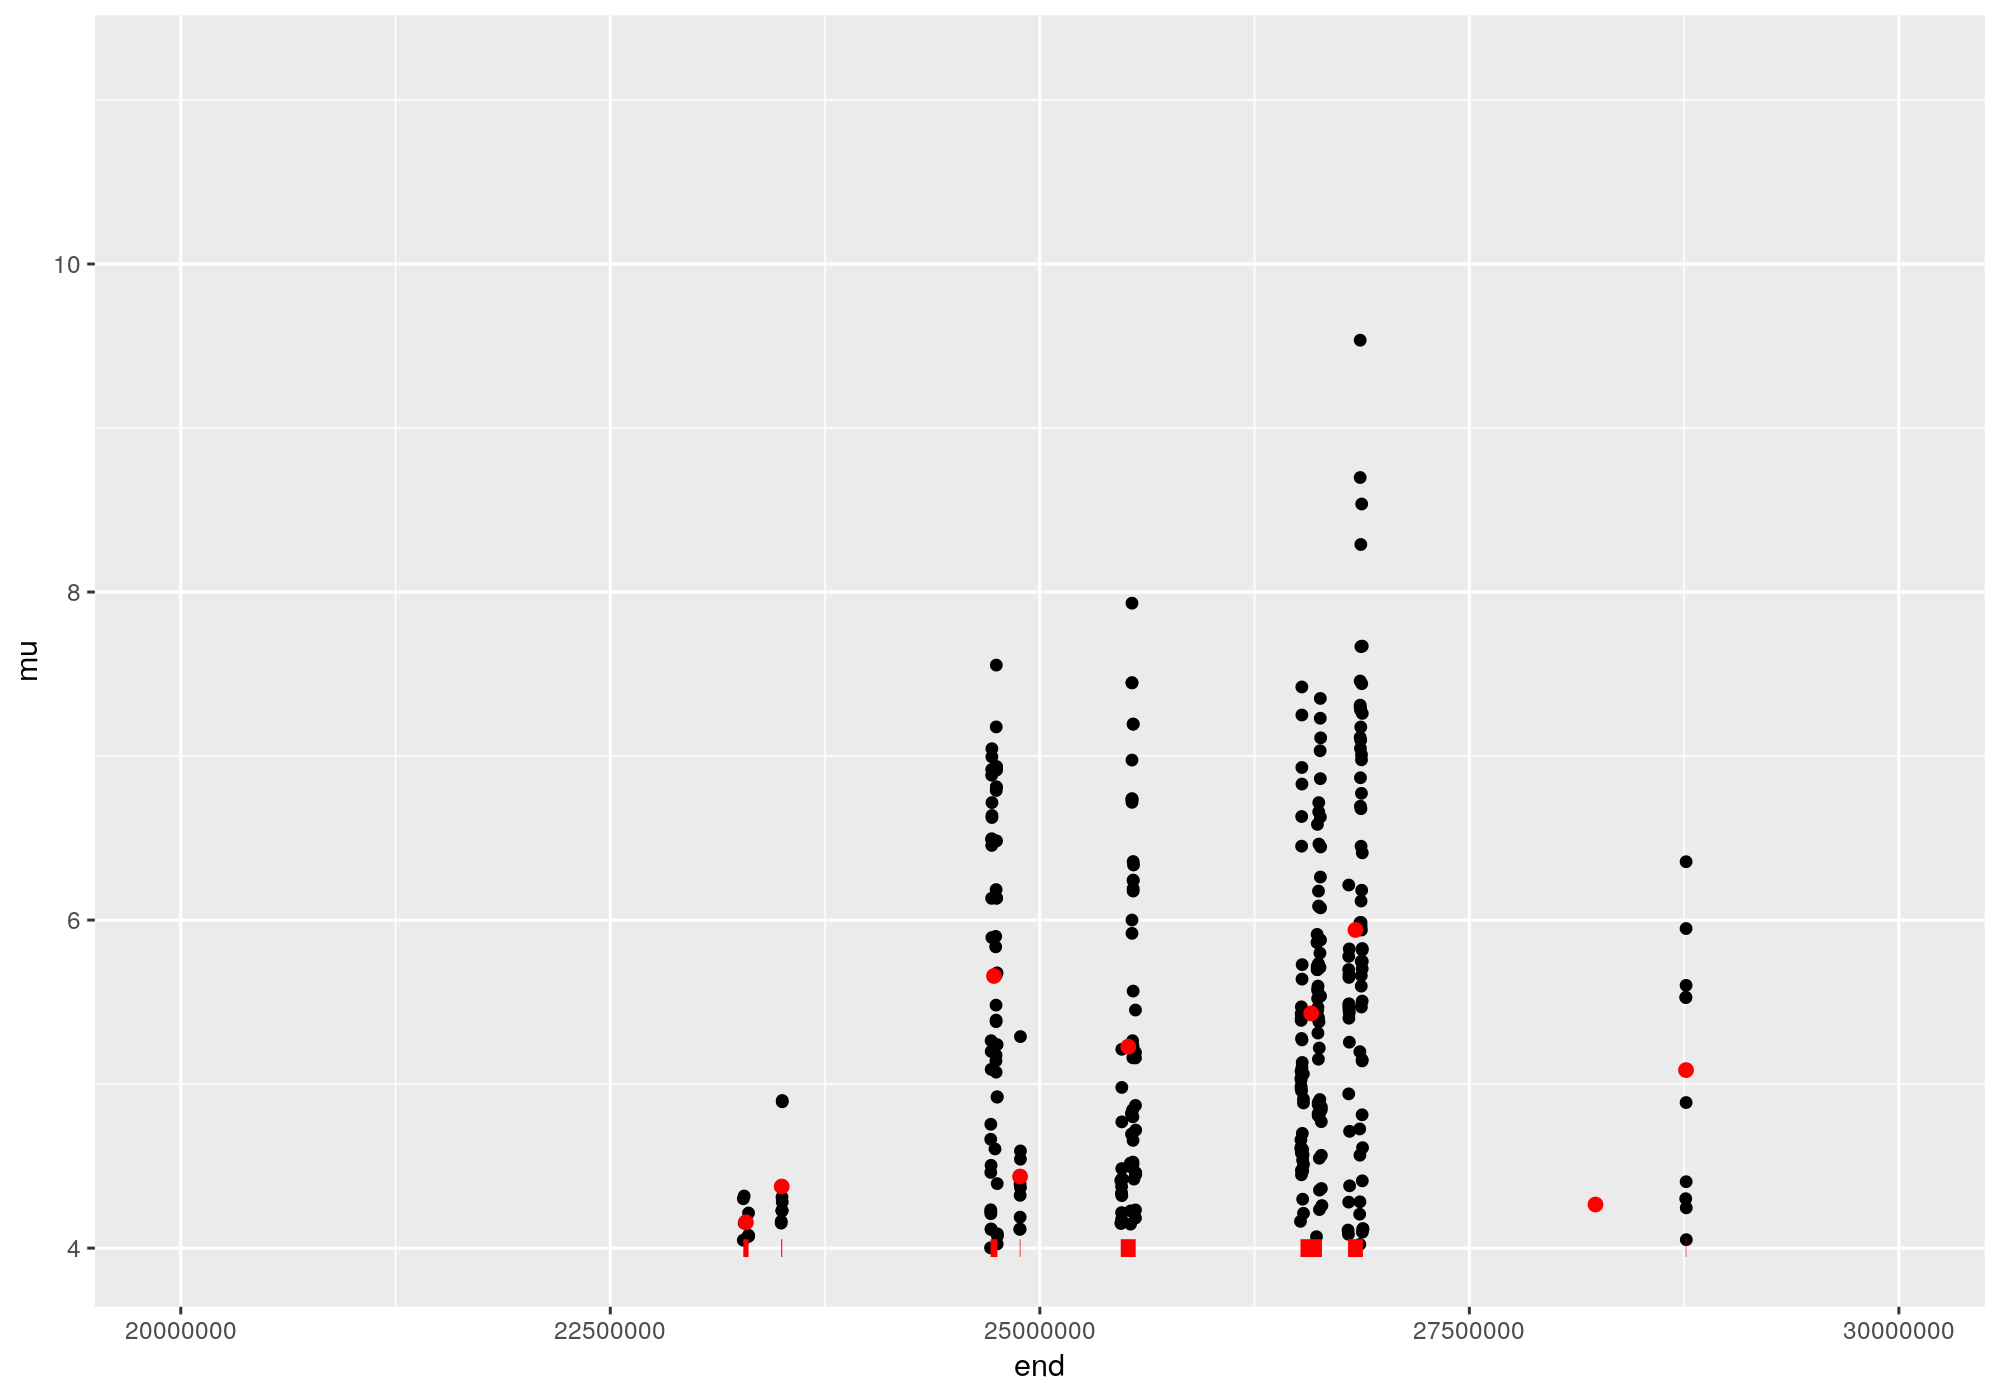

In [123]:
raisd <- vroom("../raisd_outliers", delim = "\t", 
                 col_names = c("chrom", "start", "end", "var", "sfs", "ld", "mu")) 

raisd50K <- vroom("../raisd_merge.bed", delim = "\t", 
                 col_names = c("chrom", "start", "end", "mu")) 

ggplot() +
    geom_point(data = raisd, mapping = aes(end, mu)) +
    geom_point(data = raisd50K, mapping = aes((start + end)/2, mu), size =2, colour = "red") +
    geom_segment(data = raisd50K, mapping = aes(x = start, xend = end, y = 4, yend = 4), lwd = 3, colour = "red") +
    xlim(2e7, 3e7)

In [82]:
#raisd <- vroom("../data/raisd/RAiSD_Report.v5--LR--random1_Palmar_Chico--chr10--0--152435371.txt", delim = "\t", skip = 1, 
#              col_names = c("pos", "start", "end", "var", "sfs", "ld", "mu")) %>% 
#              mutate(chrom = "chr10")    

raisd <- vroom("../data/raisd/RAiSD_Report.v5--Teo--Amatlan_de_Canas--chr2--0--243675191.corrected", delim = "\t", 
                 col_names = c("chrom", "pos", "start", "end", "var", "sfs", "ld", "mu")) %>% 
                select(-start, -end)

raisd_c <- vroom("../data/raisd/RAiSD_Report.v5--Teo--random1_Palmar_Chico--chr2--0--243675191.corrected", delim = "\t", 
                 col_names = c("chrom", "pos", "start", "end", "var", "sfs", "ld", "mu"))%>% 
                select(-start, -end)


raisd_j <- full_join(raisd, raisd_c, by = c("chrom", "pos"), suffix = c("_raw", "_corrected")) %>% drop_na()


Rows: 1,071,447
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,075,027
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



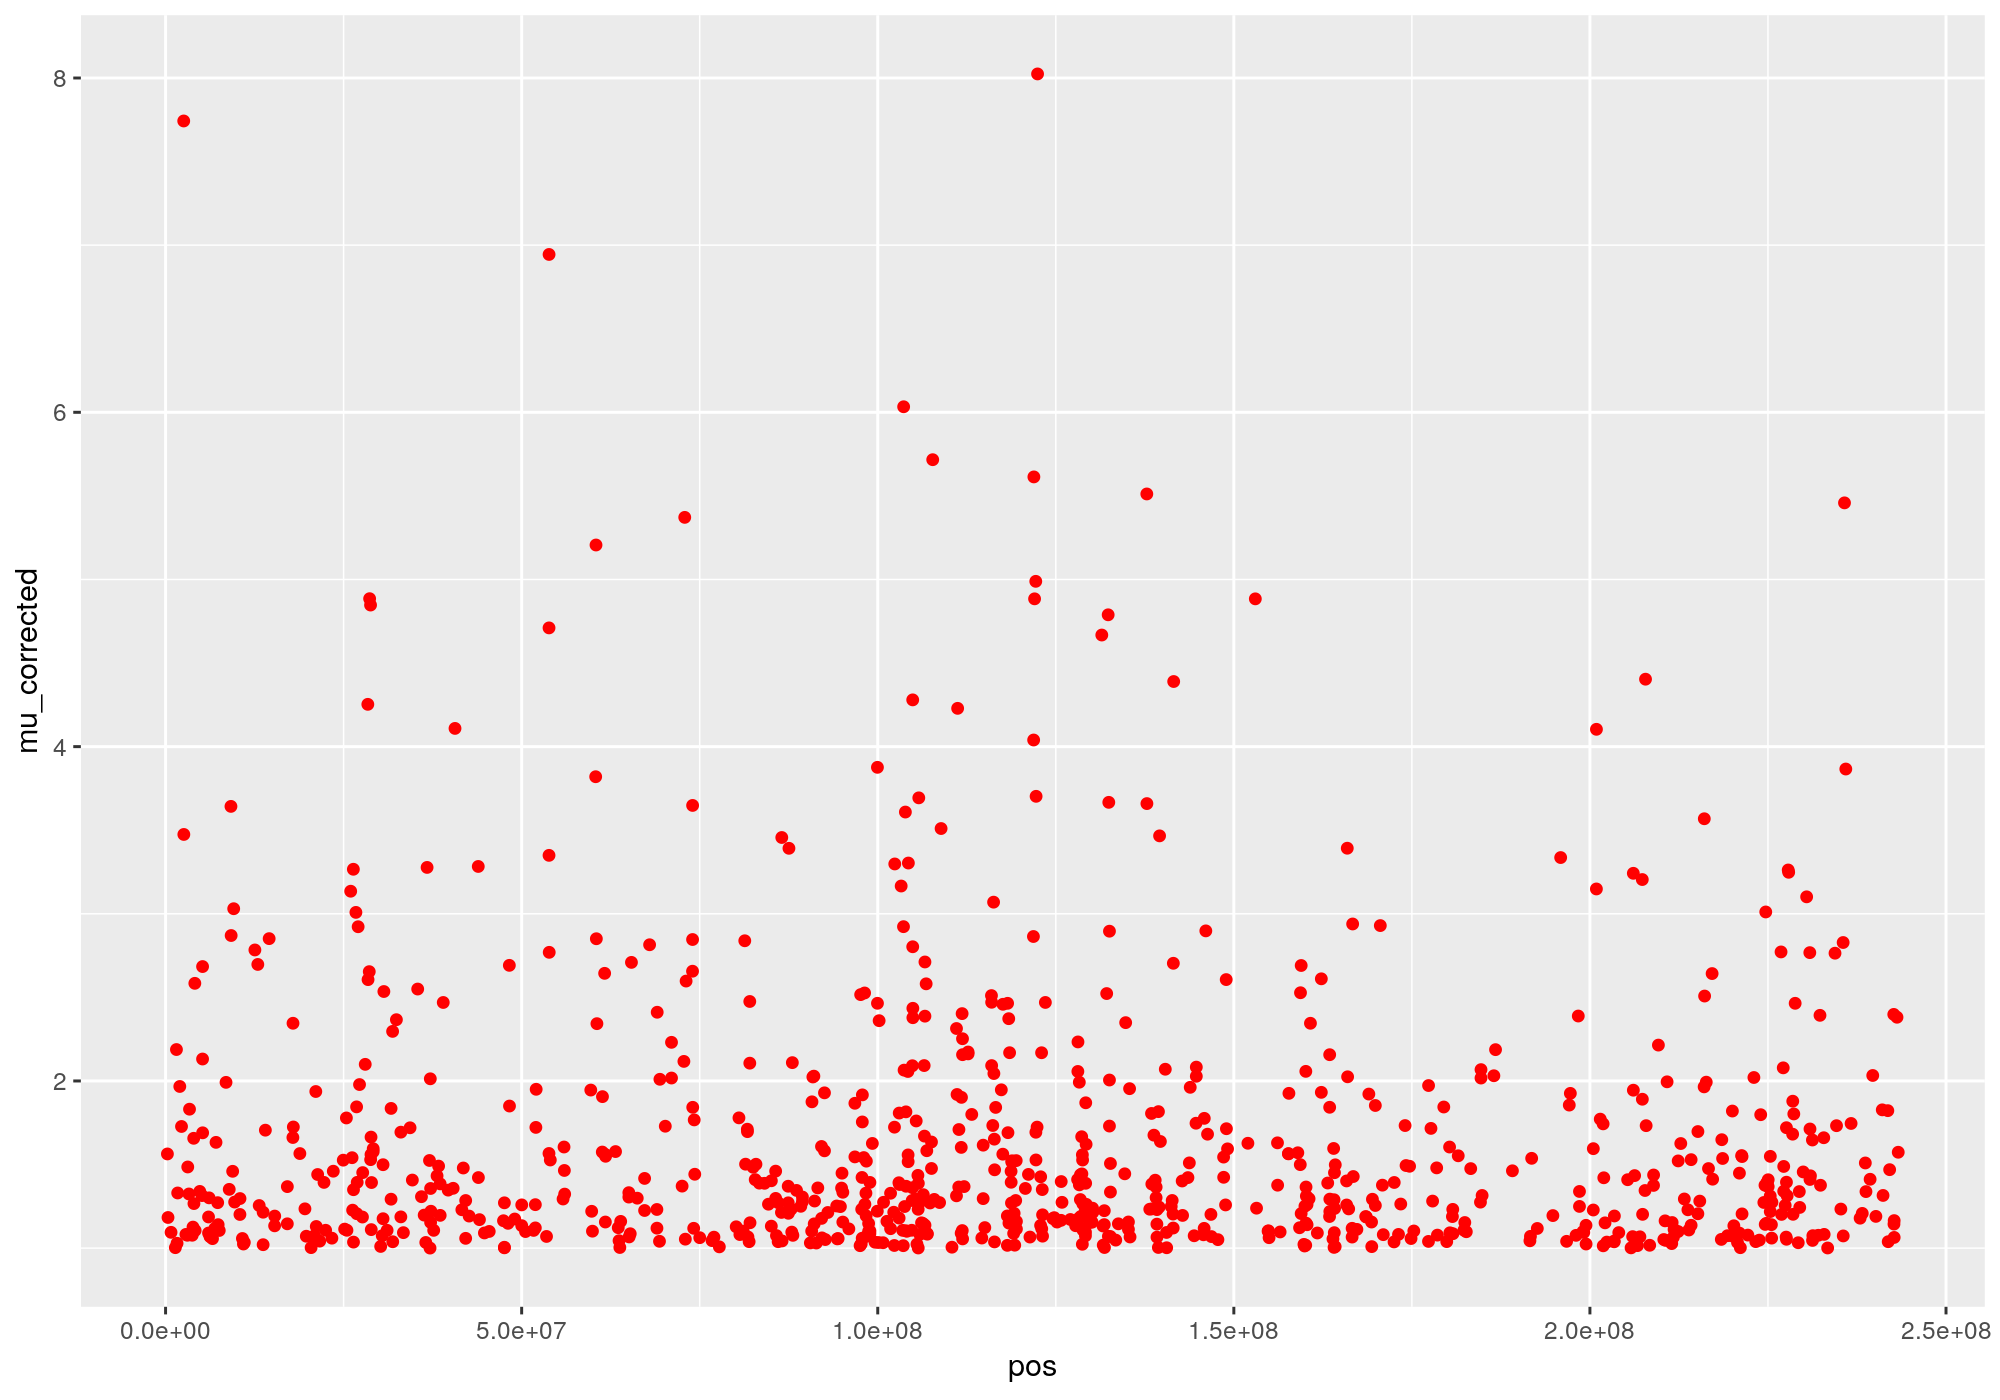

In [85]:
neutral <- 1
a <- ggplot() + geom_point(data = filter(raisd_j, mu_raw > neutral), mapping = aes(pos, mu_raw))
b <- ggplot() + geom_point(data = filter(raisd_j, mu_corrected > neutral), mapping = aes(pos, mu_corrected), colour = "red")

b   

In [37]:
head(raisd)

chrom,pos,start,end,var,sfs,ld,mu
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr2,26572,19179,33964,0.769309,0.8515,1.979,1.29638
chr2,26576,19183,33969,0.769345,0.9224,2.028,1.43916
chr2,28744,19184,38303,0.774649,0.9224,2.028,1.44908
chr2,28840,19331,38348,0.765667,0.9224,2.028,1.43228
chr2,28858,19362,38353,0.763951,0.9224,2.028,1.42907
chr2,30911,23467,38355,0.582012,0.9934,2.028,1.17253



	Pearson's product-moment correlation

data:  raisd_j$mu_raw and raisd_j$mu_corrected
t = 17.802, df = 7390, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1808185 0.2245389
sample estimates:
      cor 
0.2027797 


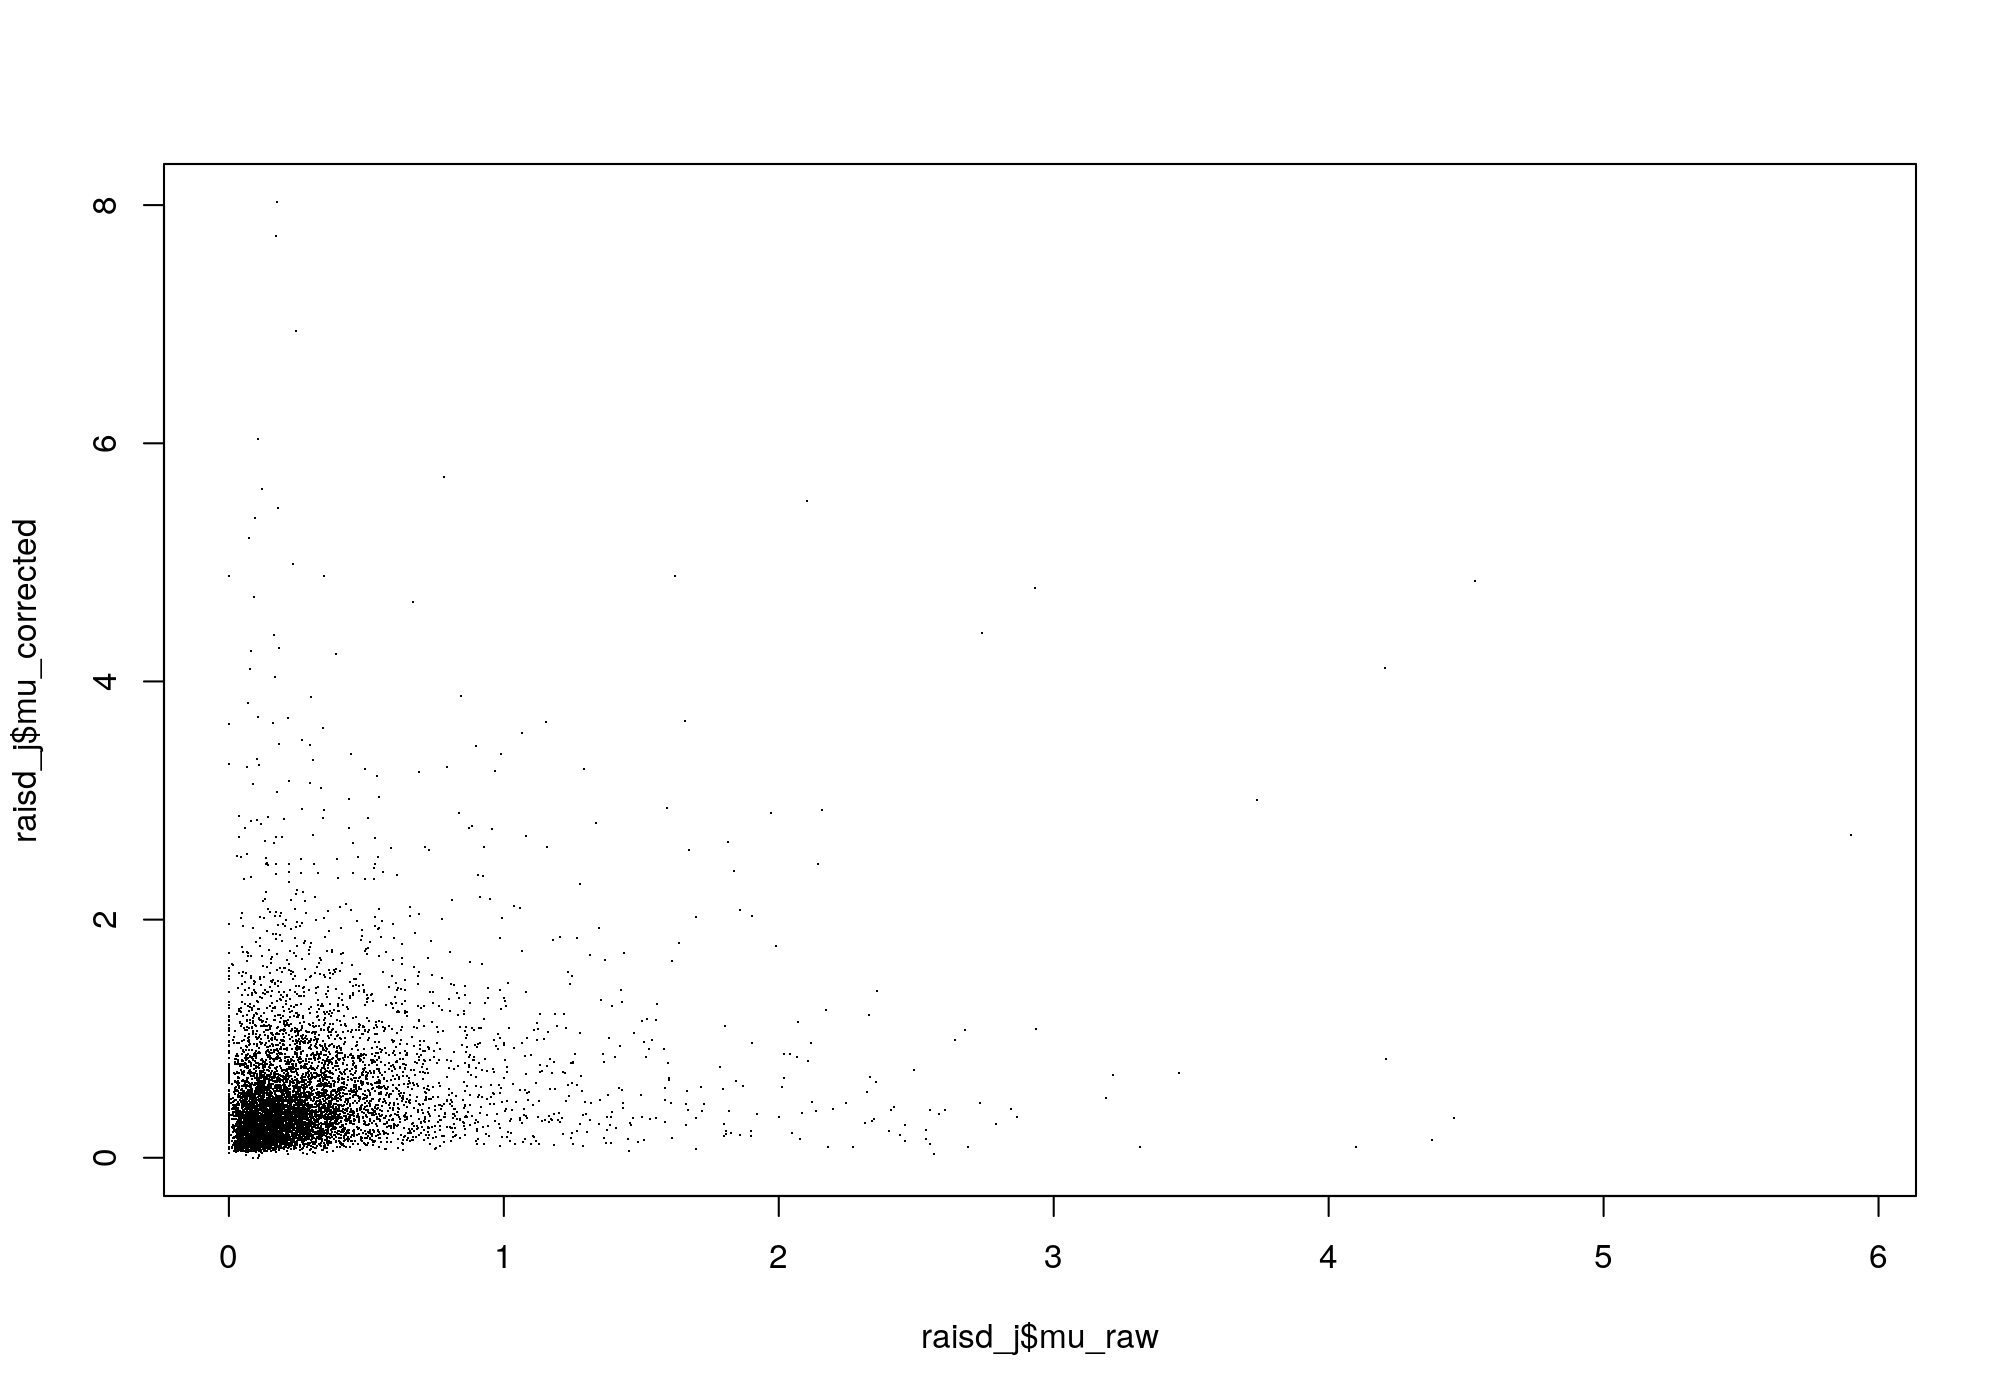

In [84]:
plot(raisd_j$mu_raw, raisd_j$mu_corrected, pch = ".")
cor.test(raisd_j$mu_raw, raisd_j$mu_corrected, method = "pe")

In [76]:
raisd_files <- sort(list.files(path = "../data/raisd/", pattern = "RAiSD_Report..*corrected", full.names = TRUE))
pop <- str_extract(raisd_files, "(v5|till1)--(LR|Teo)--(..*)--(chr[0-9][0.9]*)") %>%  str_replace("(LR|Teo)--(..*)--(chr[0-9][0.9]*)", "\\1--\\2") %>% unique()
qnt <- 0.99

pop_raised <- 
pop %>% 
    map_df(function(pop_i){
        pop_files <- sort(list.files(path = "../data/raisd/", pattern = str_glue("{pop_i}..*corrected"), full.names = TRUE))
        pop_files %>% 
        map_df(~{
            df  <- vroom(.x, delim = "\t", col_names = c("chrom", "pos", "start", "end", "var", "sfs", "ld", "mu"))
            if(nrow(df) > 0){
                ssp <- str_extract(.x, "(LR|Teo)--(..*)--(chr[0-9][0.9]*)") %>%  str_replace("(LR|Teo)--(..*)--(chr[0-9][0.9]*)", "\\1")
                pop <- str_extract(.x, "(LR|Teo)--(..*)--(chr[0-9][0.9]*)") %>%  str_replace("(LR|Teo)--(..*)--(chr[0-9][0.9]*)", "\\2")
                mutate(df, ssp_pop = str_glue("{ssp}_{pop}"), ssp = ssp, pop = pop)
            } else{
                tibble()
            }
        }) %>% 
        mutate(mu_outlier = quantile(mu, qnt)) %>% 
        filter(mu >= mu_outlier)
})

Rows: 1,360,704
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 737,217
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,139,753
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 998,601
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,140,754
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, star

Rows: 796,504
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 658,111
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 2,140,877
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,115,411
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,737,540
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, star

Rows: 737,528
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 775,401
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 819,717
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 701,652
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,239,368
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, e

Rows: 1,094,413
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 895,949
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 733,136
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 750,757
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 749,534
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, e

Rows: 910,325
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 905,268
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,066,181
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 782,501
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 617,602
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, e

Rows: 1,145,926
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 567,388
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,075,027
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 918,984
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,119,210
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, star

Rows: 752,893
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 665,097
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,352,042
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 667,029
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,276,982
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start,

In [77]:
head(pop_raised)

chrom,pos,start,end,var,sfs,ld,mu,ssp_pop,ssp,pop,mu_outlier
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<glue>,<chr>,<chr>,<dbl>
chr1,24526,15285,33766,1.49616,1.632,1.779,4.34383,LR_Amatlan_de_Canas,LR,Amatlan_de_Canas,3.783711
chr1,24564,15299,33829,1.50018,1.632,1.612,3.94666,LR_Amatlan_de_Canas,LR,Amatlan_de_Canas,3.783711
chr1,24632,15400,33863,1.49534,1.632,1.612,3.93391,LR_Amatlan_de_Canas,LR,Amatlan_de_Canas,3.783711
chr1,24639,15411,33866,1.49533,1.632,1.604,3.91437,LR_Amatlan_de_Canas,LR,Amatlan_de_Canas,3.783711
chr1,25139,15834,34444,1.54663,1.632,1.544,3.89720,LR_Amatlan_de_Canas,LR,Amatlan_de_Canas,3.783711
chr1,25193,15859,34526,1.55383,1.561,1.917,4.64975,LR_Amatlan_de_Canas,LR,Amatlan_de_Canas,3.783711


In [79]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

#BiocManager::install("IRanges")

BiocManager::install("GenomicRanges")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)

Installing package(s) 'IRanges'

also installing the dependencies ‘BiocGenerics’, ‘S4Vectors’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'backports', 'brms', 'broom', 'callr', 'data.table', 'digest',
  'DT', 'foreach', 'generics', 'globals', 'googlePolylines', 'iterators',
  'KernSmooth', 'labeling', 'lwgeom', 'nlme', 'pbdZMQ', 'R6', 'readr',
  'recipes', 'rmarkdown', 'sfheaders', 'sp', 'SQUAREM', 'stars', 'testthat',
  'tinytex', 'tmap', 'tmaptools', 'V8', 'xfun'



ERROR: Error: With R version 3.5 or greater, install Bioconductor packages using BiocManager; see https://bioconductor.org/install
